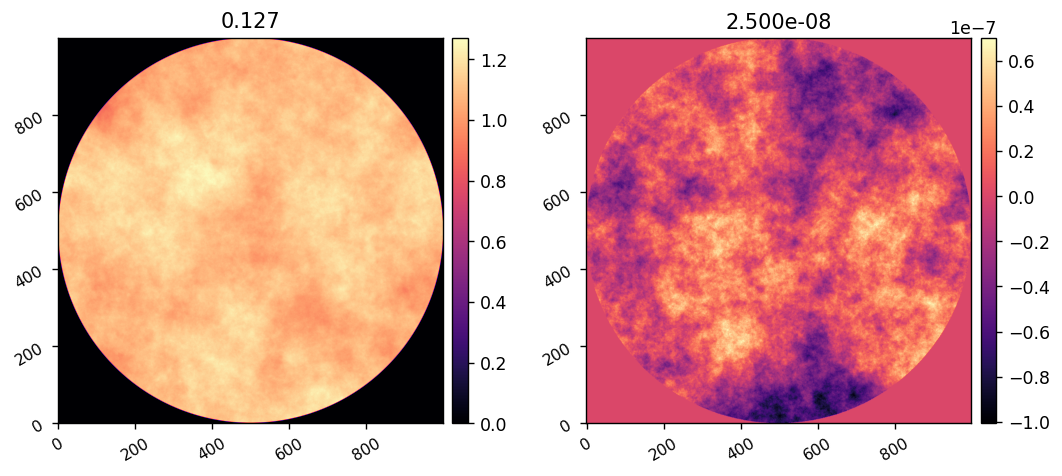

array(2.5e-08)

In [1]:
import numpy as np
import astropy.units as u
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
from importlib import reload

from matplotlib.patches import Circle

import scoobpsf
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3
import scoobpsf.compact_scoob as cscoob
import scoobpsf.dm as dm

import lina

npsf = 200

wavelength = 633*u.nm
pupil_diam = 6.75*u.mm

reload(utils)
npix = 1000
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=2.75, amp_index=3,
                                opd_rms=25*u.nm, amp_rms=0.05,
                                remove_modes=12)

wfe_amp = xp.abs(WFE)
wfe_opd = xp.angle(WFE)*wavelength.to_value(u.m)/2/np.pi
rms_amp = xp.sqrt(xp.mean(xp.square(wfe_amp[mask]-1)))
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(wfe_amp, wfe_opd,  f'{rms_amp:.3f}', f'{rms_opd:.3e}')
lina.utils.rms(wfe_opd[mask])


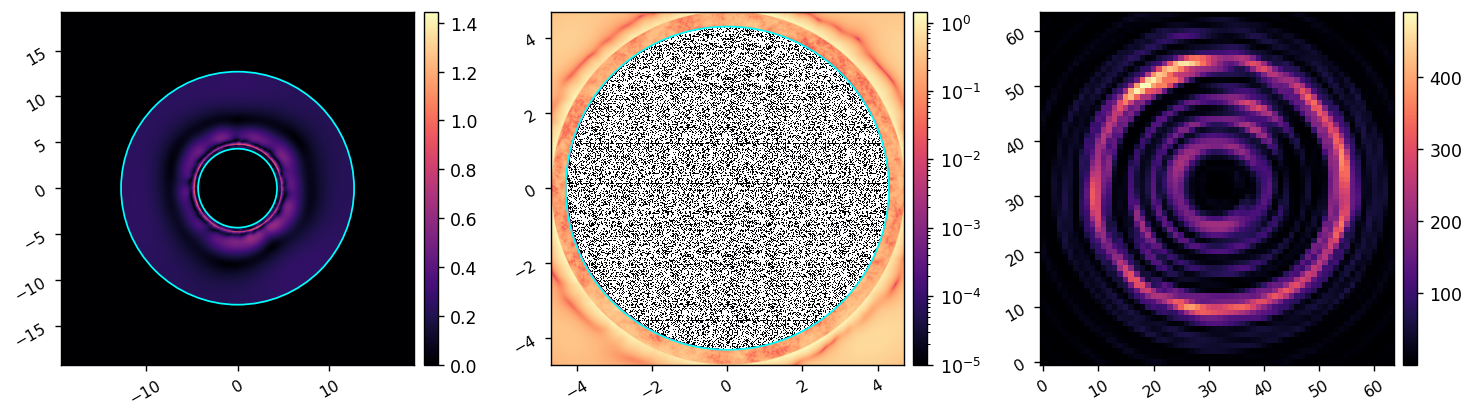

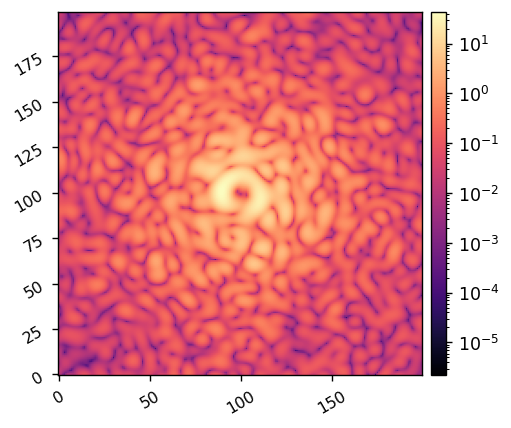

In [5]:
model = cscoob.CORO()
model.WFE = WFE
model.use_fpm = True
model.use_llowfsc()
model.llowfsc_fl = 200*u.mm

wfs = model.calc_wfs()
llowfsc_im = xp.abs(wfs[-1])**2

# imshow1(im)
imshow3(xp.abs(wfs[-2]), xp.abs(wfs[-2]), llowfsc_im, npix2=model.npix, lognorm2=True, vmin2=1e-5, 
        pxscl1=model.lyot_pupil_diam/model.npix, pxscl2=model.lyot_pupil_diam/model.npix,
        patches1=[Circle((0,0), 8.6/2, fill=False, color='cyan'),
                  Circle((0,0), 25.4/2, fill=False, color='cyan'),],
        patches2=[Circle((0,0), 8.6/2, fill=False, color='cyan'),],
                  )

model.use_llowfsc(False)
coro_im = model.snap()
imshow1(coro_im, lognorm=True)

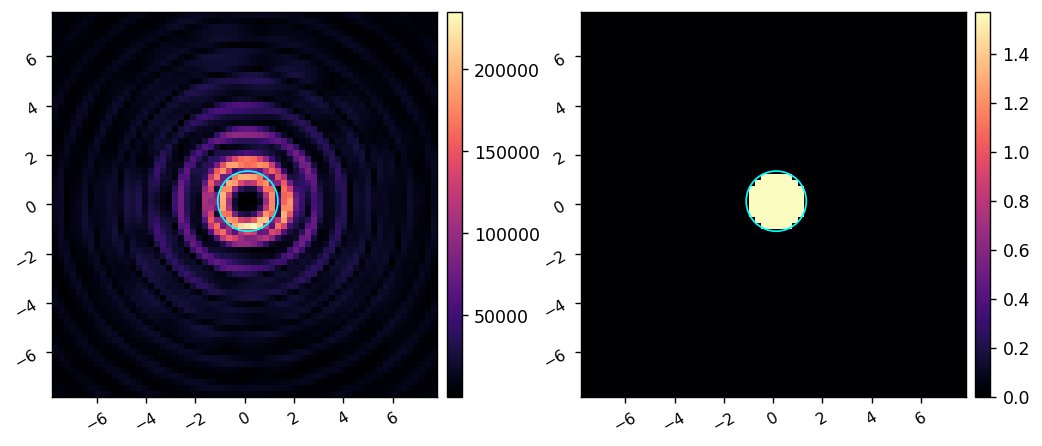

In [36]:
fpwf = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(wfs[-2])))

zwfs_phase = xp.zeros((4096, 4096))
y,x = (xp.indices((4096,4096)) - 4096//2)*1/4.096
r = xp.sqrt(x**2 + y**2)
zwfs_phase[r<=1.22] = xp.pi/2
zwfs_mask = xp.exp(1j*zwfs_phase)
imshow2(xp.abs(fpwf), zwfs_phase, npix=64, pxscl=1/4.096,
        patches1=[Circle((model.llowfsc_pixelscale_lamD/2,model.llowfsc_pixelscale_lamD/2), 1.22, fill=False, color='cyan')],
        patches2=[Circle((model.llowfsc_pixelscale_lamD/2,model.llowfsc_pixelscale_lamD/2), 1.22, fill=False, color='cyan')])

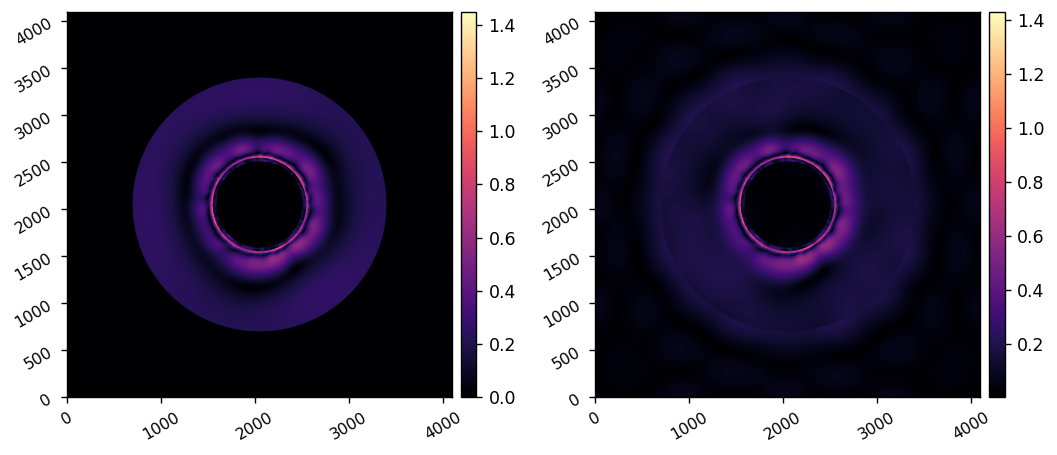

In [38]:
zwfs_wf = xp.fft.ifftshift(xp.fft.ifft2(xp.fft.fftshift(fpwf * zwfs_mask)))
imshow2(xp.abs(wfs[-2]), xp.abs(zwfs_wf),)

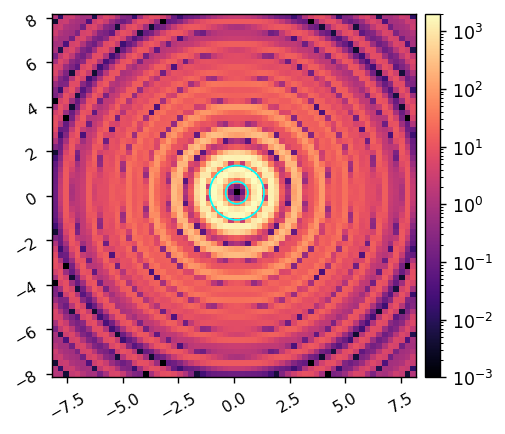

In [4]:
reload(cscoob)
model = cscoob.CORO()
# model.WFE = WFE
model.use_fpm = True
model.use_llowfsc()
model.llowfsc_fl = 200*u.mm
model.llowfsc_defocus = 0*u.mm
im = model.snap()
imshow1(im, lognorm=True, pxscl=model.llowfsc_pixelscale_lamD,
        vmin=1e-3,
        patches=[Circle((model.llowfsc_pixelscale_lamD/2,model.llowfsc_pixelscale_lamD/2), 1.22, fill=False, color='cyan'),
                 Circle((model.llowfsc_pixelscale_lamD/2,model.llowfsc_pixelscale_lamD/2), 0.5, fill=False, color='cyan')])


In [ ]:
zwfs_mask = xp.zeros()

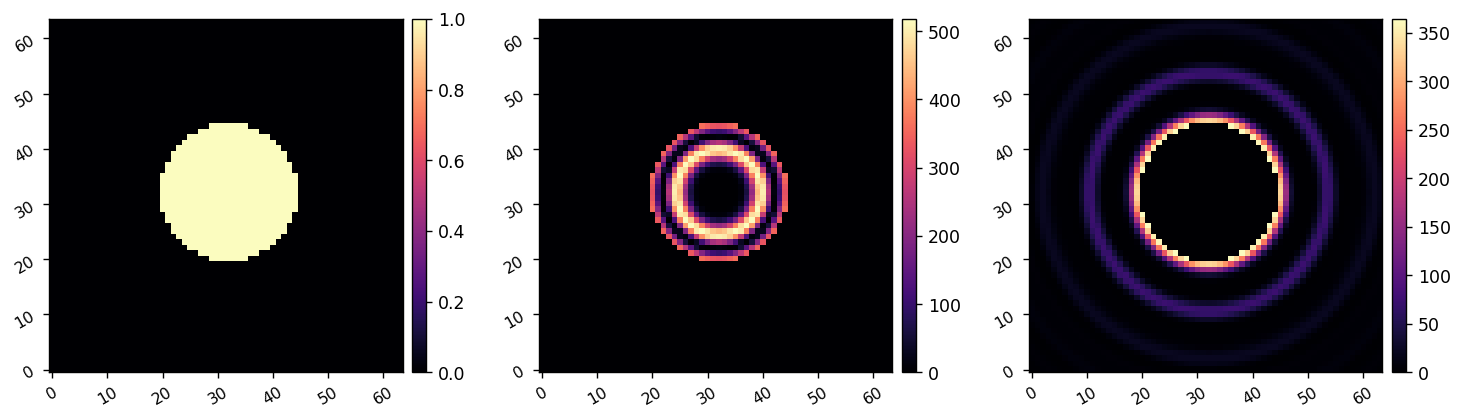

(array(101039.26477424), array(86518.32572273), array(1.16783657))

In [40]:
x = xp.linspace(-64//2, 64//2-1, 64) * model.llowfsc_pixelscale_lamD
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2 + y**2)

llowfsc_mask = r<1.6
imshow3(llowfsc_mask, llowfsc_mask*im, ~llowfsc_mask*im)
xp.sum(llowfsc_mask*im), xp.sum(~llowfsc_mask*im), xp.sum(llowfsc_mask*im)/xp.sum(~llowfsc_mask*im)

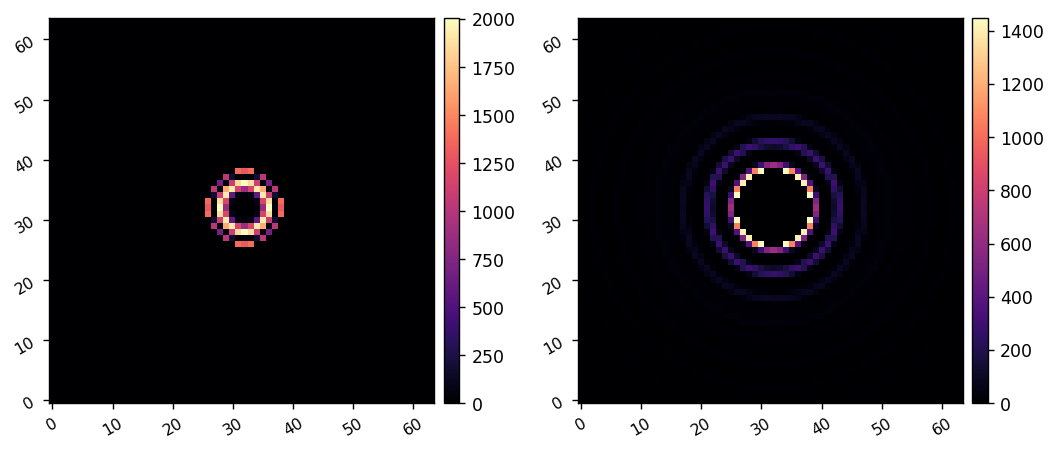

(array(99378.02090825), array(107506.88091635), array(0.92438754))

In [33]:
imshow2(llowfsc_mask*im, ~llowfsc_mask*im)
xp.sum(llowfsc_mask*im), xp.sum(~llowfsc_mask*im), xp.sum(llowfsc_mask*im)/xp.sum(~llowfsc_mask*im)

In [11]:
%timeit model.snap()

38.7 ms ± 69.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
N_llowfsc_waves = 5
bw = 0.2
wavelength_c = 633*u.nm
llowfsc_waves = np.linspace(wavelength_c*(1 - bw/2), wavelength_c*(1 + bw/2), N_llowfsc_waves)
print(llowfsc_waves)

[569.7  601.35 633.   664.65 696.3 ] nm


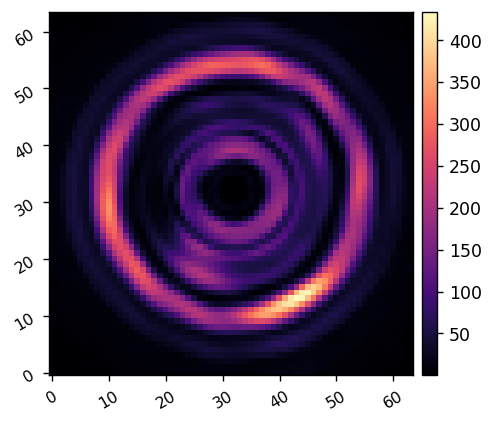

In [18]:
def snap():
    im = xp.zeros((64,64))
    for i in range(5): 
        model.wavelength = llowfsc_waves[i]
        im += model.snap()/5
    return im
imshow1(snap())

In [14]:
%timeit snap()

116 ms ± 157 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit snap()

193 ms ± 258 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


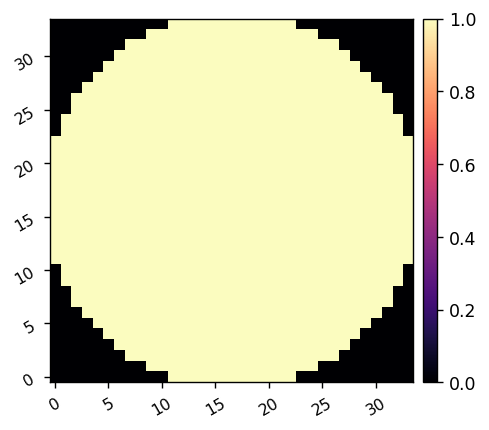

array(952)

In [3]:
dm_mask = xp.ones((model.Nact,model.Nact), dtype=bool)
xx = (xp.linspace(0, model.Nact-1, model.Nact) - model.Nact/2 + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(model.Nact+1)/2] = 0
imshow1(dm_mask)
dm_mask.sum()

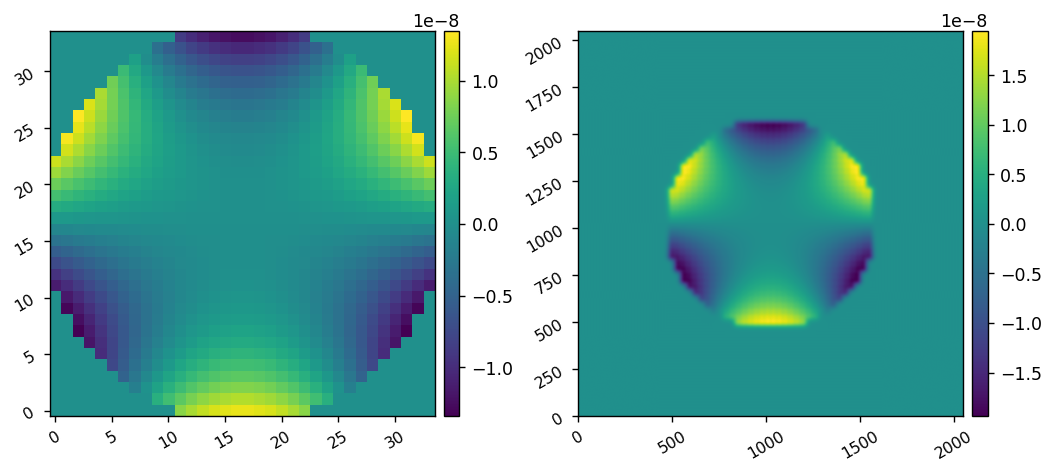

In [4]:
dm_zernikes = lina.utils.create_zernike_modes(dm_mask, nmodes=25 + 1)[1:]
model.set_dm(dm_zernikes[7]*5e-9)
imshow2(dm_zernikes[7]*5e-9, model.DM.get_surface(), cmap1='viridis', cmap2='viridis')
model.reset_dm()


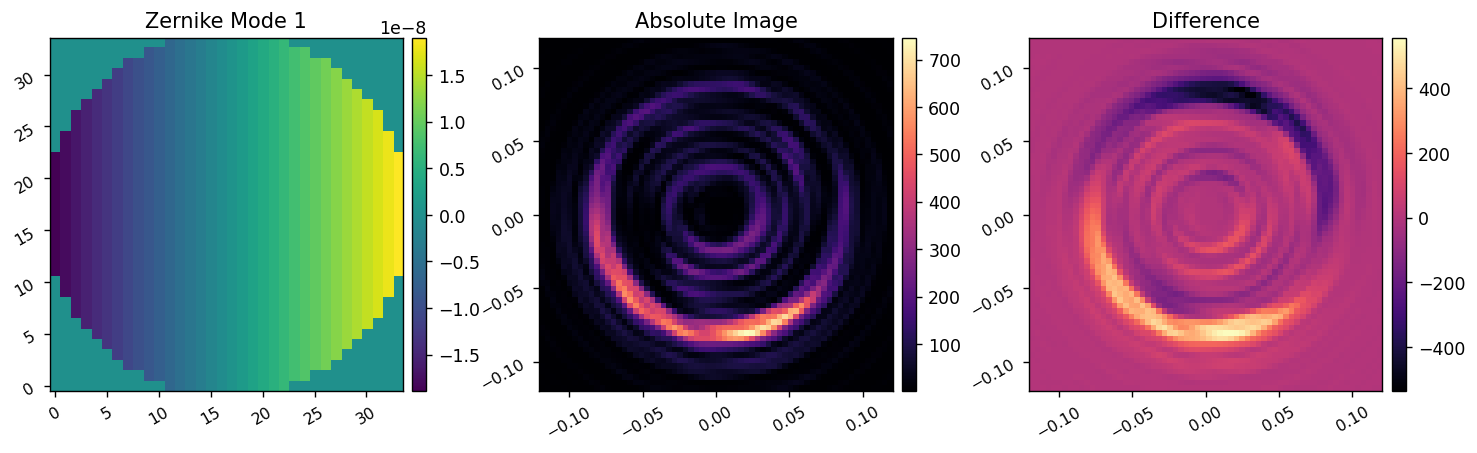

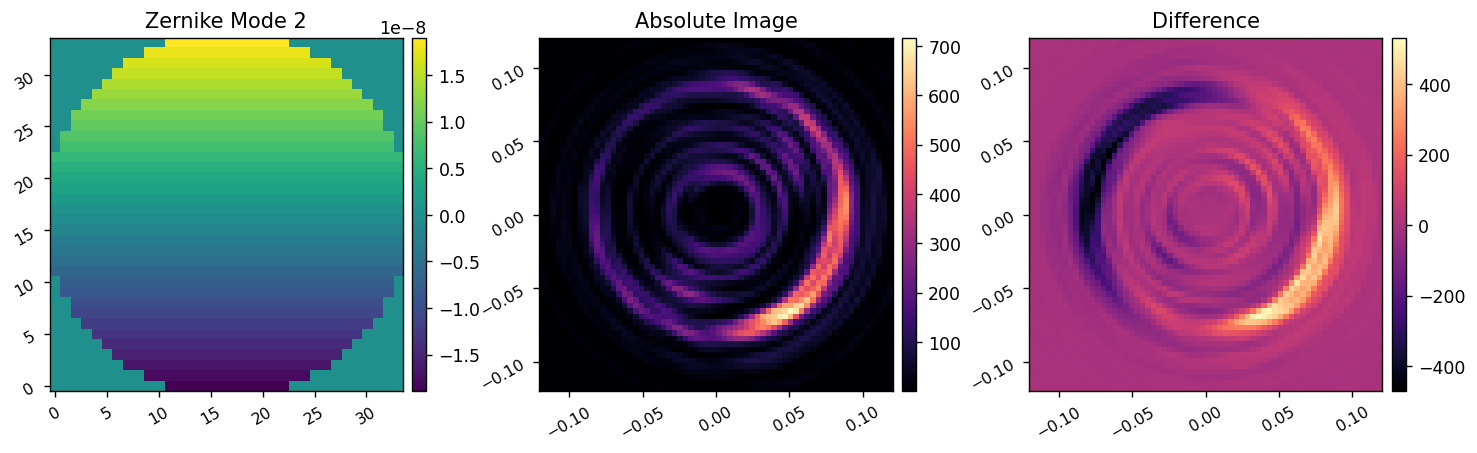

In [5]:
amp = 10e-9

model.use_llowfsc()

model.reset_dm()
model.WFE = WFE

im_ref = model.snap()

N = 2
responses = xp.zeros((N, model.nllowfsc**2))
for i in range(N):
    mode = dm_zernikes[i]
    # model.RETRIEVED = poppy.ArrayOpticalElement(opd=mode*1e-8, pixelscale=model.pupil_diam/(2*model.npix*u.pix))
    # im_pos = model.snap()

    model.set_dm(amp*mode)
    im_pos = model.snap()
    model.add_dm(-amp*mode)
    
    # diff = im_pos-im_ref
    # responses[i] = diff.flatten()/amp
    
    model.add_dm(-amp*mode)
    im_neg = model.snap()
    model.add_dm(amp*mode)

    diff = im_pos - im_neg
    responses[i] = diff.flatten()/(2*amp)

    imshow3(amp*mode, im_pos, diff, f'Zernike Mode {i+1}', 'Absolute Image', 'Difference', 
            pxscl2=model.llowfsc_pixelscale.to(u.mm/u.pix), pxscl3=model.llowfsc_pixelscale.to(u.mm/u.pix), 
            cmap1='viridis')

response_matrix = responses.T

In [8]:
U, s, Vt = xp.linalg.svd(response_matrix, full_matrices=False)
s.max()/s.min()

array(1.10602814)

In [6]:
# control_matrix = lina.utils.beta_reg(response_matrix, -10)
control_matrix = lina.utils.TikhonovInverse(response_matrix, 1e-15)

# load in the low-order WFE time series

In [98]:
from astropy.io import fits
import copy

pointing_error_time_series = xp.array(fits.getdata('pointing_error_time_series.fits'))
pointing_error_time_series[1,:] *= 100e-9
pointing_error_time_series[2,:] *= 100e-9

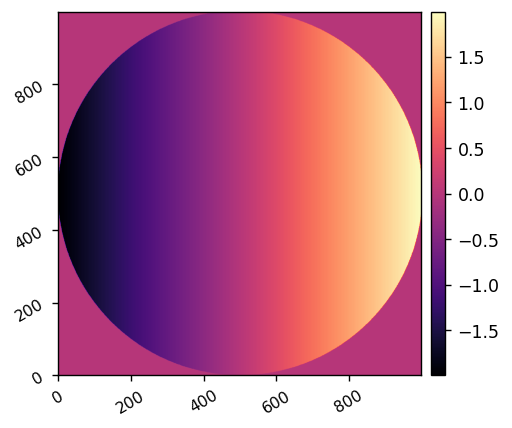

In [29]:
pointing_modes = lina.utils.create_zernike_modes(model.APERTURE, nmodes=2, remove_modes=1)
imshow1(pointing_modes[0])

In [44]:
pointing_error_time_series.shape

(3, 2097152)

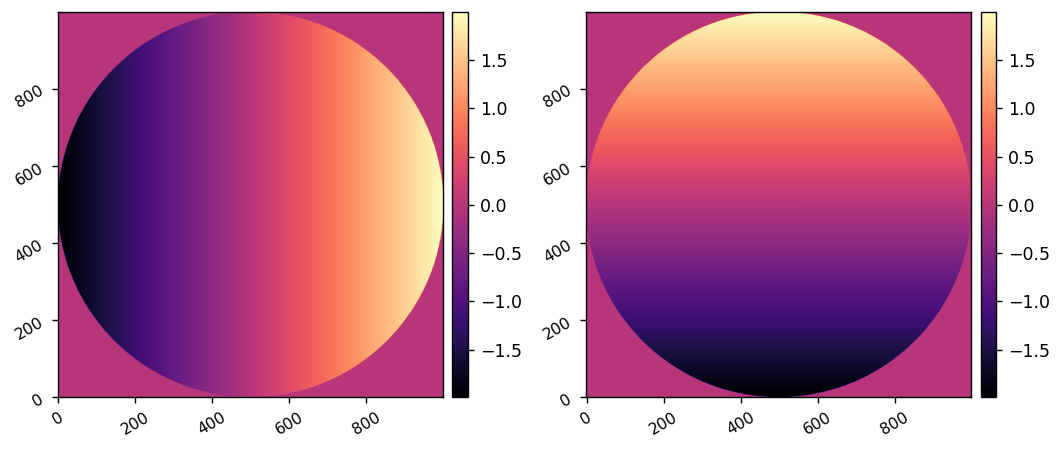

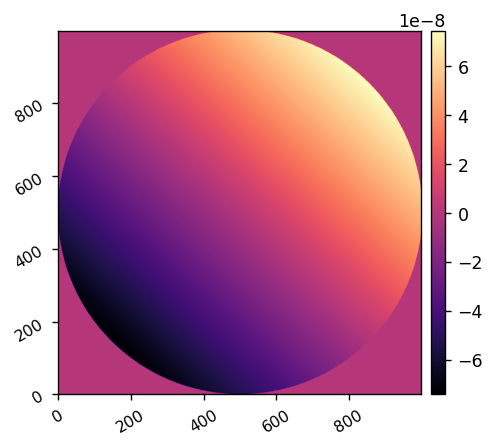

In [100]:
from astropy.io import fits
import copy

pointing_modes = lina.utils.create_zernike_modes(model.APERTURE, nmodes=2, remove_modes=1)
imshow2(pointing_modes[0], pointing_modes[1])

pointing_error_time_series = xp.array(fits.getdata('pointing_error_time_series.fits'))
pointing_error_time_series[1,:] *= 100e-9
pointing_error_time_series[2,:] *= 100e-9

start_i = 1000
lo_wfe = pointing_modes.reshape(2, npix**2).T.dot(pointing_error_time_series[1:,i]).reshape(npix,npix)
imshow1(lo_wfe)

N = 1000
time_series = xp.zeros((3,N))
for i in range(N):
    time_series[:,i] = pointing_error_time_series[:,start_i + i*5]

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['image.origin']='lower'

import matplotlib
from matplotlib.animation import FFMpegWriter, PillowWriter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['animation.html'] = 'html5'
plt.rcParams.update({'image.origin': 'lower',
                     'image.interpolation':'nearest'})

def create_anim(arrs):
    numframes = arrs.shape[0]
    print(numframes)

    fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(5,5),dpi=125)
    
    im1 = ax.imshow(arrs[0,:,:],)
    im1_title = ax.set_title(f'WFE: Time = {0.0:.2e}s', fontsize = 18)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.075)
    cbar = fig.colorbar(im1, cax=cax)

    def animate(i):
        im1.set_data(arrs[i,:,:])
        im1_title.set_text(f'WFE: Time = {wfe_times[i]:.2e}s')
        im1.set_clim(vmin=np.min(arrs[i,:,:]), vmax=np.max(arrs[i,:,:]))

    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=numframes, )
    return anim

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:figure size in inches has been adjusted from 5.0 x 5.0 to 4.992 x 4.992
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 624x624 -pix_fmt rgba -r 5.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp2bkgju9b/temp.m4v


100


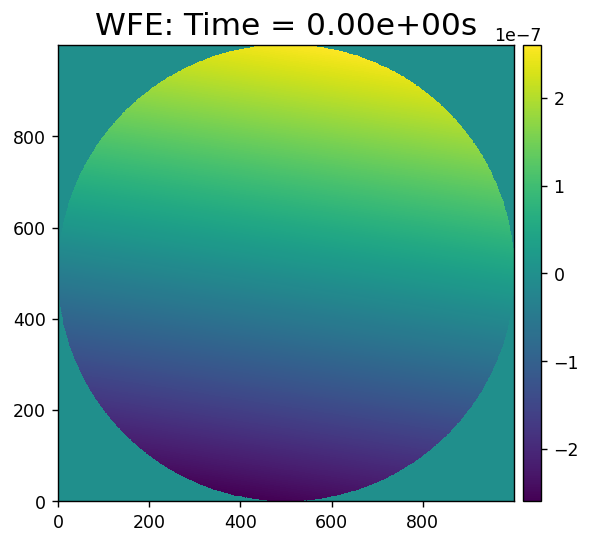

In [15]:
create_anim(pointing_wfe.get())

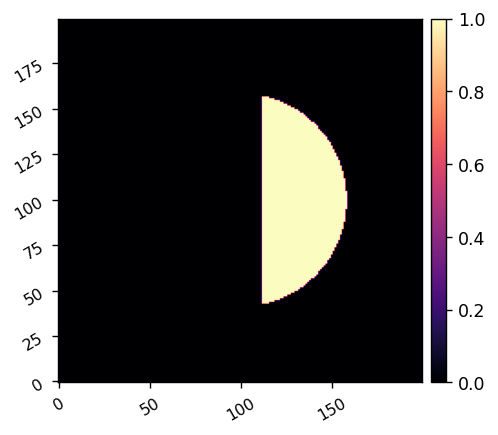

3.5912087668977574e-10


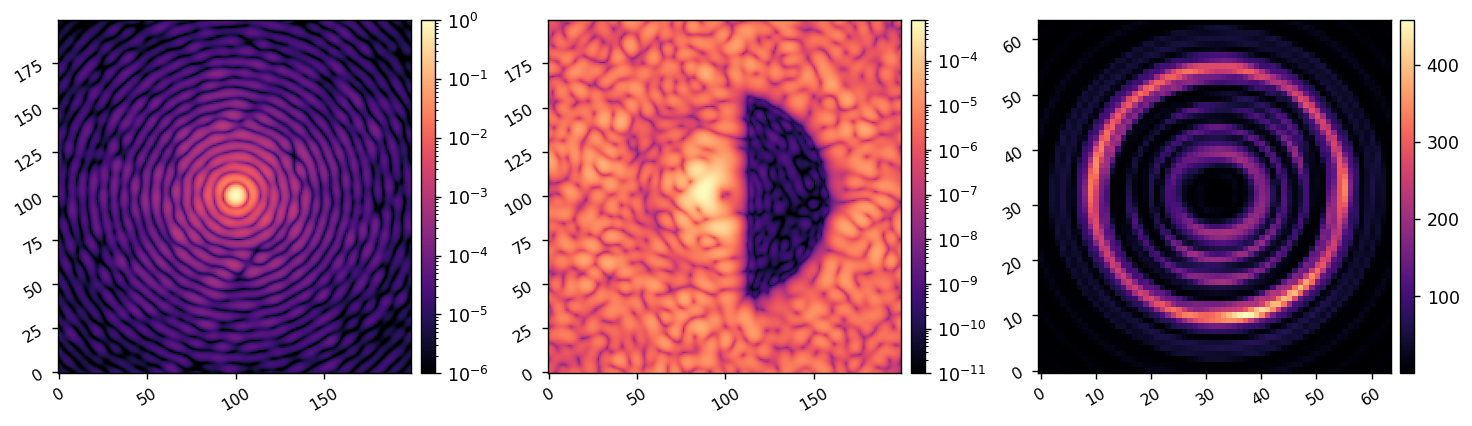

In [85]:
dark_hole_command = xp.array(fits.getdata('dark_hole_command.fits'))
model.dm_ref = dark_hole_command
model.set_dm(dark_hole_command)

model.WFE = WFE

model.use_llowfsc(False)
model.use_fpm = False
ref_psf = model.snap()
model.Imax_ref = xp.max(ref_psf)

model.use_fpm = True
coro_im = model.snap()

control_mask = lina.utils.create_annular_focal_plane_mask(model, 2,10,2, plot=True)
mean_contrast = xp.mean(coro_im[control_mask])

model.use_llowfsc()
llowfsc_im = model.snap()

print(mean_contrast)
imshow3(ref_psf/model.Imax_ref, coro_im, llowfsc_im, lognorm1=True, lognorm2=True, vmin1=1e-6, vmin2=1e-11, )


In [104]:
reload(lina)
reload(lina.llowfsc)

Nitr = 100
time_series = xp.zeros((3,Nitr))
for i in range(Nitr):
    time_series[:,i] = pointing_error_time_series[:,i*5]

# model.WFE = WFE * xp.exp(1j*2*np.pi*lo_wfe/model.wavelength_c.to_value(u.m))
model.reset_dm()

coro_ims, llowfsc_ims = lina.llowfsc.run_model(model, 
                                                WFE, 
                                                ref_im=im_ref, 
                                                control_matrix=control_matrix, 
                                                control_modes=dm_zernikes[:2],
                                                time_series=time_series[:,:Nitr], 
                                                zernike_modes=pointing_modes, 
                                                control_mask=control_mask, 
                                                return_all=True, 
                                                # plot=True, 
                                                )

Starting LLOWFSC control-loop simulation: delta T = 2.5000e-03s


Total mean contrast: 5.760e-09
Total mean contrast: 5.760e-09


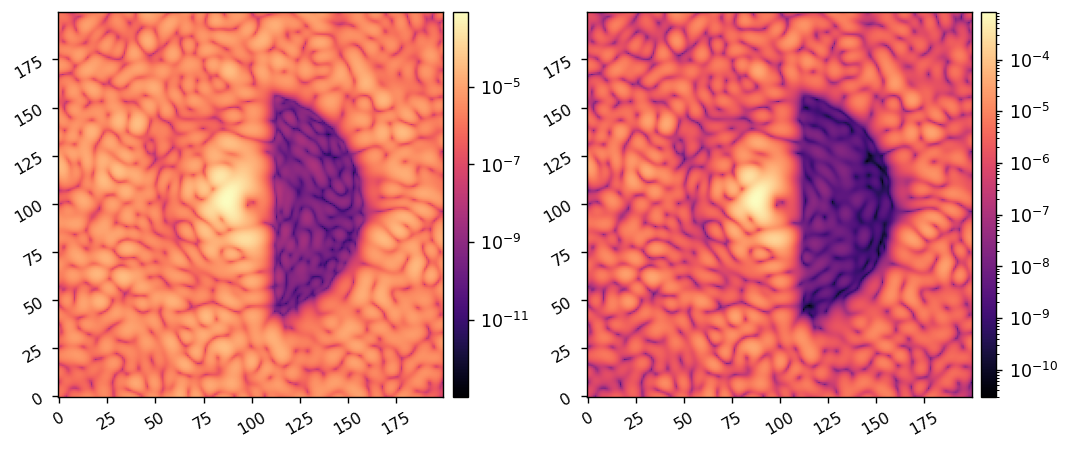

In [105]:
mean_contrasts = xp.mean(coro_ims[:,control_mask], axis=1)
total_mean_contrast = xp.mean(mean_contrasts[5:]) # ignore the first three iterations where we have to converge to a solution first
print(f'Total mean contrast: {total_mean_contrast:.3e}')

mean_coro_im = xp.mean(coro_ims[5:], axis=0)
total_mean_contrast = xp.mean(mean_coro_im[control_mask]) # ignore the first three iterations where we have to converge to a solution first
print(f'Total mean contrast: {total_mean_contrast:.3e}')

diff_ims = llowfsc_ims - im_ref

imshow2(coro_ims[0], mean_coro_im, lognorm=True)